In [1]:
# including the project directory to the notebook level
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import warnings

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    from keras import backend as K
    # from nn_source import models as mp
from dataprocess import dataprocessor as dp
import models as mp

Using TensorFlow backend.


In [3]:
"""This test checks that HyperOpt is functional.

It also checks that it is usable with a separate scheduler.
"""
import ray
from ray.tune import run
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
import argparse
from hyperopt import hp

# Data Loading and Processing for CHW energy prediction

In [4]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [5]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# Total energy is sum of heating and coling
ahu['totale'] = ahu['hwe'] + ahu['cwe']
# dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [6]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

# rearranging columns
# df = df[['oat', 'orh', 'sat', 'Ghi', 'flow', 'totale']]

In [7]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.08  # 0.15
)

In [8]:
df_smoothed.head()

,oat,orh,sat,hwe,cwe,totale,Ghi,flow
2018-07-12 13:55:00,89.540007,76.124299,75.452788,-7.298009e-203,35.394834,35.394834,876.016155,42.912385
2018-07-12 14:00:00,89.956063,75.071752,75.428564,-1.082760e-202,34.681891,34.681891,866.009680,42.291643
2018-07-12 14:05:00,90.371926,74.039353,75.402423,-1.503792e-202,33.998174,33.998174,855.850879,41.682143
2018-07-12 14:10:00,90.784966,73.053268,75.373602,-1.989847e-202,33.368230,33.368230,845.537770,41.094187
2018-07-12 14:15:00,91.191286,72.138646,75.341511,-2.531615e-202,32.811968,32.811968,835.074894,40.549747


Finished 'dataframeplot' in 0.1003 secs


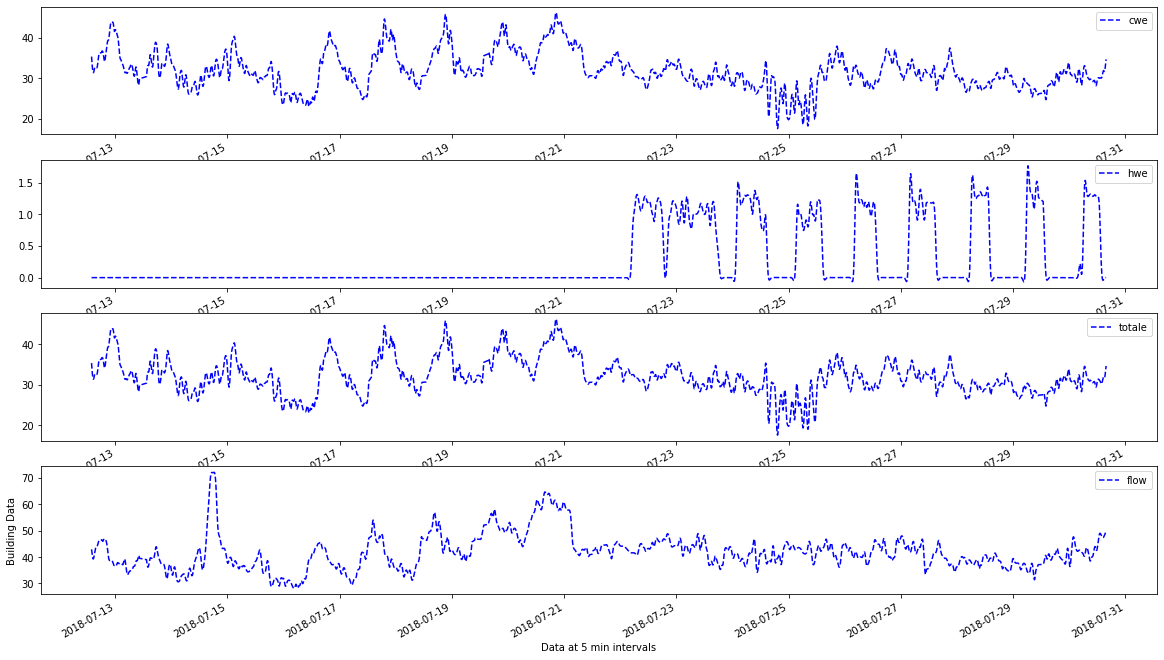

In [9]:
dp.dataframeplot(df=df_smoothed.loc[df_smoothed.index[0:5000],['cwe','hwe','totale','flow']],
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [10]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df_smoothed, subsequence=True, period=1, days=7, hours=0)

In [11]:
len(dflist)

10

In [12]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'Ghi', 'flow'],
        outputcols=['cwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [13]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [14]:
def objective_function(config, reporter):
    
    modeldesigndone = False
    initial_epoch = 0
    for weekdata in config['weeklist']:
        
        X_train = weekdata['X_train']
        y_train = weekdata['y_train']
        X_test = weekdata['X_test']
        y_test = weekdata['y_test']
    
        if not modeldesigndone:
            
            try:
                del model
            except NameError:
                pass

            K.clear_session()
            
            #Instantiate learner model
            model = mp.lstm_model(inputdim=X_train.shape[-1], outputdim = y_train.shape[-1], period = 1)

            # Desing model architecture
            model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']]*config['lstm_no_layers'], 
                           densehiddenlayers=[config['dense_hidden_units']]*config['dense_no_layers'], 
                       dropoutlist=[[], []], batchnormalizelist=[[], []])
            
            # creating early stopping and learning reate changing callbacks
            model.model_callbacks()
            
            modeldesigndone = False
        
        # train the model
        history = model.train_model(X_train, y_train, X_test, y_test, epochs = 300, initial_epoch = initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # evaluate the model for metrics at this stage
        cvrmse, mae = model.evaluate_model(X_train, y_train, X_test, y_test)

        # reporter for tracking performance of individual process/ ray process
        # note if it is reported betwen weekly data loop, then training might stop at the middle of the loop
        reporter(test_cvrmse=sum(cvrmse[1])/len(cvrmse[1]))
    

In [15]:
ray.init()

2020-03-13 18:48:06,586	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-13 18:48:06,588	INFO resource_spec.py:212 -- Starting Ray with 36.28 GiB memory available for workers and up to 18.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-13 18:48:07,006	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '129.59.104.221',
 'redis_address': '129.59.104.221:54279',
 'object_store_address': '/tmp/ray/session_2020-03-13_18-48-06_583355_20216/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-13_18-48-06_583355_20216/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-03-13_18-48-06_583355_20216'}

In [16]:
space = {
    'lstm_hidden_units': hp.choice("lstm_hidden_units", [1, 2, 4, 8, 16]),
    'lstm_no_layers': hp.choice("lstm_no_layers", [1, 2, 4, 8]),
    'dense_hidden_units': hp.choice("dense_hidden_units", [1, 2, 4, 8, 16, 32]),
    'dense_no_layers' : hp.choice("dense_no_layers", [1, 2, 4, 8]),
}

config = {
    "num_samples": 150,
    "verbose":1,
    "resources_per_trial":{"cpu": 0.30},
    "config":{'weeklist':weeklist}
}

algo = HyperOptSearch(
    space,
    max_concurrent=60,
    metric="test_cvrmse",
    mode="min")


scheduler = AsyncHyperBandScheduler(
    metric="test_cvrmse",
    mode="min")

In [17]:
analysis = run(objective_function, 
               search_alg=algo, 
               scheduler=scheduler, 
               **config)

Trial name,status,loc,lstm_hidden_units,dense_no_layers,lstm_no_layers,dense_hidden_units,total time (s),iter
objective_function_63de8614,TERMINATED,,8,8,2,2,58.4942,1
objective_function_574bb958,TERMINATED,,8,8,2,2,135.97,4
objective_function_50f304c6,TERMINATED,,8,8,2,2,138.161,4
objective_function_4f816f2f,TERMINATED,,8,8,2,2,230.352,10
objective_function_4f816f2e,TERMINATED,,8,8,2,2,162.851,4
objective_function_4a858899,TERMINATED,,2,8,8,8,107.023,1
objective_function_4a858898,TERMINATED,,1,1,2,32,35.0111,1
objective_function_44d6d492,TERMINATED,,16,2,1,4,35.6049,1
objective_function_43d524e1,TERMINATED,,16,8,4,16,67.3711,1
objective_function_43d524e0,TERMINATED,,16,1,2,16,225.301,10


2020-03-13 19:00:58,551	INFO tune.py:352 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [18]:
for i in space.keys():
    print("Best config for {} is".format(i), analysis.get_best_config(metric="test_cvrmse")[i])
print('----------Based on min mode')
for i in space.keys():
    print("Best config for {} is".format(i), analysis.get_best_config(metric="test_cvrmse",mode='min')[i])

Best config for lstm_hidden_units is 4
Best config for lstm_no_layers is 1
Best config for dense_hidden_units is 1
Best config for dense_no_layers is 8
----------Based on min mode
Best config for lstm_hidden_units is 1
Best config for lstm_no_layers is 1
Best config for dense_hidden_units is 32
Best config for dense_no_layers is 2


In [19]:
ray.shutdown()

In [20]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ~/ray_results/objective_function/

# Data loading and processing for Hot Water Energy

In [4]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [5]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654


Finished 'dataframeplot' in 0.0587 secs


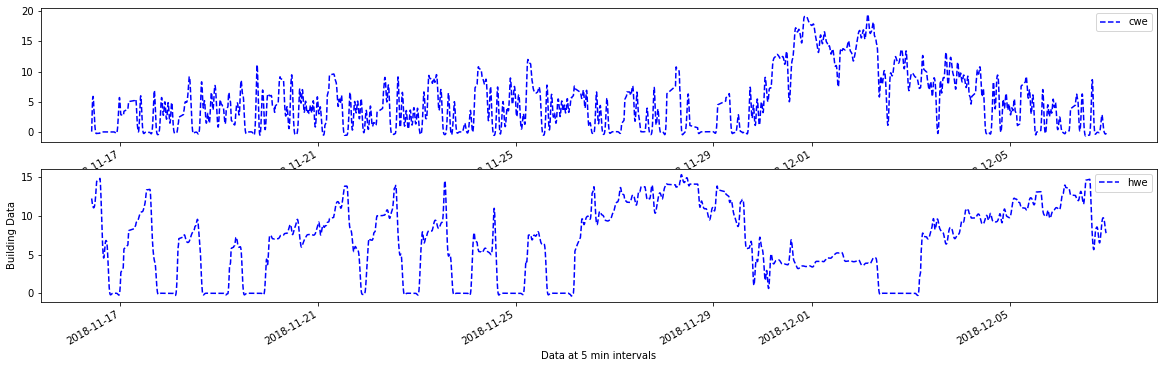

In [6]:
# look at a segment of the dataframe
dp.dataframeplot(df=df.loc[df.index[0:5000],['cwe','hwe']],
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [7]:
# Creating a list of 7 day dataframes for training
dflist = dp.df2dflist(df, subsequence=True, period=1, days=7, hours=0)

In [8]:
len(dflist)

7

In [9]:
# create list of training, testing arrays
weeklist = []
for weekdata in dflist:
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        weekdata,
        predictorcols=['oat', 'orh', 'sat', 'ghi', 'hw_sf'],
        outputcols=['hwe'],
        scaling=True,
        feature_range=(0,1),
        reshaping=True,
        lag=-1
    )
    weeklist.append({
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
    })

In [10]:
weeklist[0].keys()
for key,value in weeklist[0].items():
    print("name: {}, value: {}".format(key, value.shape))

name: X_train, value: (1511, 1, 5)
name: y_train, value: (1511, 1, 1)
name: X_test, value: (504, 1, 5)
name: y_test, value: (504, 1, 1)


In [11]:
def objective_function_hwe(config, reporter):
    
    modeldesigndone = False
    initial_epoch = 0
    for weekdata in config['weeklist']:
        
        X_train = weekdata['X_train']
        y_train = weekdata['y_train']
        X_test = weekdata['X_test']
        y_test = weekdata['y_test']
    
        if not modeldesigndone:
            
            try:
                del model
            except NameError:
                pass

            K.clear_session()
            
            #Instantiate learner model
            model = mp.lstm_model(inputdim=X_train.shape[-1], outputdim = y_train.shape[-1], period = 1)

            # Desing model architecture
            model.design_model(lstmhiddenlayers=[config['lstm_hidden_units']]*config['lstm_no_layers'], 
                           densehiddenlayers=[config['dense_hidden_units']]*config['dense_no_layers'], 
                       dropoutlist=[[], []], batchnormalizelist=[[], []])
            
            # creating early stopping and learning reate changing callbacks
            model.model_callbacks()
            
            modeldesigndone = False
        
        # train the model
        history = model.train_model(X_train, y_train, X_test, y_test, epochs = 300, initial_epoch = initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # evaluate the model for metrics at this stage
        cvrmse, mae = model.evaluate_model(X_train, y_train, X_test, y_test)

        # reporter for tracking performance of individual process/ ray process
        # note if it is reported betwen weekly data loop, then training might stop at the middle of the loop
        reporter(test_cvrmse=sum(cvrmse[1])/len(cvrmse[1]))
    

In [12]:
ray.init()

2020-03-17 15:22:19,152	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-17 15:22:19,155	INFO resource_spec.py:212 -- Starting Ray with 36.43 GiB memory available for workers and up to 18.22 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-17 15:22:19,588	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '129.59.104.221',
 'redis_address': '129.59.104.221:54855',
 'object_store_address': '/tmp/ray/session_2020-03-17_15-22-19_151624_3475/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-17_15-22-19_151624_3475/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-03-17_15-22-19_151624_3475'}

In [13]:
space = {
    'lstm_hidden_units': hp.choice("lstm_hidden_units", [1, 2, 4, 8, 16]),
    'lstm_no_layers': hp.choice("lstm_no_layers", [1, 2, 4, 8]),
    'dense_hidden_units': hp.choice("dense_hidden_units", [1, 2, 4, 8, 16, 32]),
    'dense_no_layers' : hp.choice("dense_no_layers", [1, 2, 4, 8]),
}

config = {
    "num_samples": 150,
    "verbose":1,
    "resources_per_trial":{"cpu": 0.30},
    "config":{'weeklist':weeklist}
}

algo = HyperOptSearch(
    space,
    max_concurrent=60,
    metric="test_cvrmse",
    mode="min")


scheduler = AsyncHyperBandScheduler(
    metric="test_cvrmse",
    mode="min")

In [14]:
analysis = run(objective_function_hwe, 
               search_alg=algo, 
               scheduler=scheduler, 
               **config)

Trial name,status,loc,lstm_no_layers,lstm_hidden_units,dense_no_layers,dense_hidden_units,total time (s),iter
objective_function_hwe_fb308ca7,TERMINATED,,4,2,2,16,31.855,1
objective_function_hwe_fb308ca6,TERMINATED,,4,2,2,16,216.671,4
objective_function_hwe_fa737a44,TERMINATED,,4,2,2,16,33.9966,1
objective_function_hwe_f51636d7,TERMINATED,,4,2,2,16,34.2691,1
objective_function_hwe_f51636d6,TERMINATED,,4,8,2,2,33.9817,1
objective_function_hwe_f3d31be2,TERMINATED,,4,2,8,32,276.612,4
objective_function_hwe_f3d31be1,TERMINATED,,4,2,4,16,218.798,4
objective_function_hwe_f3d31be0,TERMINATED,,4,2,8,2,37.135,1
objective_function_hwe_e960e3e0,TERMINATED,,4,2,8,4,316.054,4
objective_function_hwe_e26f1f16,TERMINATED,,4,2,4,16,322.967,4


2020-03-17 15:36:08,442	INFO tune.py:352 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [15]:
for i in space.keys():
    print("Best config for {} is".format(i), analysis.get_best_config(metric="test_cvrmse")[i])
print('----------Based on min mode')
for i in space.keys():
    print("Best config for {} is".format(i), analysis.get_best_config(metric="test_cvrmse",mode='min')[i])

Best config for lstm_hidden_units is 16
Best config for lstm_no_layers is 4
Best config for dense_hidden_units is 8
Best config for dense_no_layers is 4
----------Based on min mode
Best config for lstm_hidden_units is 16
Best config for lstm_no_layers is 1
Best config for dense_hidden_units is 16
Best config for dense_no_layers is 2


In [16]:
ray.shutdown()

In [ ]:
# %tensorboard --logdir ~/ray_results/objective_function_hwe/